Vérification de CFL de Maxwell
===

Il s'agit ici de vérifier un calcul de CFL lié à Maxwell dans RK(3,3) suite à un mail de Nicolas du 4 novembre 2020 à 16h21.

In [1]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

In [2]:
k = sp.symbols("k",real=True)
dt = sp.symbols(r"\Delta\ t",real=True,positive=True)

In [3]:
A = sp.Matrix([
        [ 0      ,  0      ,  0     , sp.I*k ],
        [ 0      ,  0      , -sp.I*k, 0      ],
        [ 0      , -sp.I*k ,  0     , 0      ],
        [ sp.I*k ,  0      ,  0     , 0      ],
    ])
U = sp.MatrixSymbol("U^n",4,1)

A

Matrix([
[  0,    0,    0, I*k],
[  0,    0, -I*k,   0],
[  0, -I*k,    0,   0],
[I*k,    0,    0,   0]])

In [4]:
# Maintenant on écrit notre RK(3,3)
def rk33(un,L,dt):
    u1 = un + dt*L*un
    u2 = sp.Rational(3,4)*un + sp.Rational(1,4)*u1 + sp.Rational(1,4)*dt*L*u1
    return sp.Rational(1,3)*un + sp.Rational(2,3)*u2 + sp.Rational(2,3)*dt*L*u2

In [5]:
# vérification de notre méthode RK
L = sp.symbols("L")
un = sp.symbols("u_n")

rk33(un,L,dt).expand().collect(un).subs(L,sp.symbols(r"\lambda"))

u_n*(\Delta t**3*\lambda**3/6 + \Delta t**2*\lambda**2/2 + \Delta t*\lambda + 1)

Maintenant on test avec la matrice $A$ à la place du symbole $L$, et le vecteur $U$ en lieu et place de $u_n$.

In [6]:
sp.Matrix(rk33(U,A,dt).expand().simplify())

Matrix([
[-I*\Delta t**3*k**3*U^n[3, 0]/6 - \Delta t**2*k**2*U^n[0, 0]/2 + I*\Delta t*k*U^n[3, 0] + U^n[0, 0]],
[ I*\Delta t**3*k**3*U^n[2, 0]/6 - \Delta t**2*k**2*U^n[1, 0]/2 - I*\Delta t*k*U^n[2, 0] + U^n[1, 0]],
[ I*\Delta t**3*k**3*U^n[1, 0]/6 - \Delta t**2*k**2*U^n[2, 0]/2 - I*\Delta t*k*U^n[1, 0] + U^n[2, 0]],
[-I*\Delta t**3*k**3*U^n[0, 0]/6 - \Delta t**2*k**2*U^n[3, 0]/2 + I*\Delta t*k*U^n[0, 0] + U^n[3, 0]]])

Je n'ai pas trouvé de méthode simple avec `sympy` pour écrire cela sous la forme $B_{A,\Delta t}\cdot U$. Donc je le fais à la main pour trouver la matrice :

$$
  \begin{pmatrix}
      1 - \frac{\Delta t^2k^2}{2} & 0 & 0 & i\Delta tk - \frac{i\Delta t^3k^3}{6} \\
      0 & 1 - \frac{\Delta t^2k^2}{2} & -i\Delta tk + \frac{i\Delta t^3k^3}{6} & 0 \\
      0 & -i\Delta tk + \frac{i\Delta t^3k^3}{6} & 1 - \frac{\Delta t^2k^2}{2} & 0 \\
      i\Delta tk - \frac{i\Delta t^3k^3}{6} & 0 & 0 & 1 - \frac{\Delta t^2k^2}{2} \\
  \end{pmatrix}
$$

J'ai préféré utiliser cette méthode pour ne pas supposer une quelconque commutativité de A avec... A

Le polynôme de stabilité appliqué en dt*A fonctionne très bien

In [7]:
sp.eye(4)+dt*A + sp.Rational(1,2)*dt**2*A**2 + sp.Rational(1,6)*dt**3*A**3

Matrix([
[             -\Delta t**2*k**2/2 + 1,                                   0,                                   0, -I*\Delta t**3*k**3/6 + I*\Delta t*k],
[                                   0,             -\Delta t**2*k**2/2 + 1, I*\Delta t**3*k**3/6 - I*\Delta t*k,                                    0],
[                                   0, I*\Delta t**3*k**3/6 - I*\Delta t*k,             -\Delta t**2*k**2/2 + 1,                                    0],
[-I*\Delta t**3*k**3/6 + I*\Delta t*k,                                   0,                                   0,              -\Delta t**2*k**2/2 + 1]])

In [8]:
dtk = dt*k
B = sp.Matrix([
    [ 1-sp.Rational(1,2)*dtk**2 , 0 , 0 , sp.I*dtk - sp.Rational(1,6)*sp.I*dtk**3 ],
    [ 0 , 1-sp.Rational(1,2)*dtk**2 , -sp.I*dtk + sp.Rational(1,6)*sp.I*dtk**3 , 0 ],
    [ 0 , -sp.I*dtk + sp.Rational(1,6)*sp.I*dtk**3 , 1-sp.Rational(1,2)*dtk**2 , 0 ],
    [ sp.I*dtk - sp.Rational(1,6)*sp.I*dtk**3 , 0 , 0 , 1-sp.Rational(1,2)*dtk**2 ],
])
B

Matrix([
[             -\Delta t**2*k**2/2 + 1,                                   0,                                   0, -I*\Delta t**3*k**3/6 + I*\Delta t*k],
[                                   0,             -\Delta t**2*k**2/2 + 1, I*\Delta t**3*k**3/6 - I*\Delta t*k,                                    0],
[                                   0, I*\Delta t**3*k**3/6 - I*\Delta t*k,             -\Delta t**2*k**2/2 + 1,                                    0],
[-I*\Delta t**3*k**3/6 + I*\Delta t*k,                                   0,                                   0,              -\Delta t**2*k**2/2 + 1]])

In [9]:
sp.Matrix(B*U).expand()

Matrix([
[-I*\Delta t**3*k**3*U^n[3, 0]/6 - \Delta t**2*k**2*U^n[0, 0]/2 + I*\Delta t*k*U^n[3, 0] + U^n[0, 0]],
[ I*\Delta t**3*k**3*U^n[2, 0]/6 - \Delta t**2*k**2*U^n[1, 0]/2 - I*\Delta t*k*U^n[2, 0] + U^n[1, 0]],
[ I*\Delta t**3*k**3*U^n[1, 0]/6 - \Delta t**2*k**2*U^n[2, 0]/2 - I*\Delta t*k*U^n[1, 0] + U^n[2, 0]],
[-I*\Delta t**3*k**3*U^n[0, 0]/6 - \Delta t**2*k**2*U^n[3, 0]/2 + I*\Delta t*k*U^n[0, 0] + U^n[3, 0]]])

Maintenant calculons les valeurs propres de $B$.

In [10]:
ev = B.eigenvals()

for v,m in ev.items():
    display(v.collect(sp.I))
    print("multiplicity of ",m)

-\Delta t**2*k**2/2 + I*(-\Delta t**3*k**3/6 + \Delta t*k) + 1

multiplicity of  2


-\Delta t**2*k**2/2 + I*(\Delta t**3*k**3/6 - \Delta t*k) + 1

multiplicity of  2


Maintenant on trace le module de ces valeurs propres pour différentes valeurs de $\Delta tk$.

-1.7171717171717171 1.7171717171717176
-1.7171717171717171 1.7171717171717176


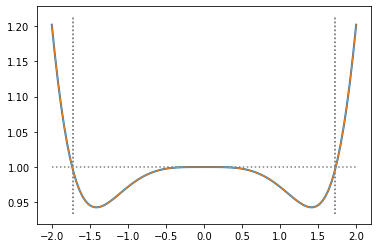

In [11]:
nK = np.linspace(-2,2,100)

for i,v in enumerate(ev):
    evk = sp.lambdify(k,v.subs(dt,1))(nK)
    kmin = np.amin(nK[np.where(np.abs(evk)<1.0)])
    kmax = np.amax(nK[np.where(np.abs(evk)<1.0)])
    print(kmin,kmax)
    plt.plot(nK,np.abs(evk),linewidth=2-i)
    plt.vlines(kmin,np.amin(np.abs(evk))*0.99,np.max(np.abs(evk))*1.01,colors="gray",linestyles="dotted")
    plt.vlines(kmax,np.amin(np.abs(evk))*0.99,np.max(np.abs(evk))*1.01,colors="gray",linestyles="dotted")
plt.hlines(1.0,-2,2,colors="gray",linestyles="dotted")

J'en conclus qu'il faut que $\Delta tk \leq 1.71$ pour assurer la stabilité. Sachant que $k$ sont les fréquences de Fourier, donc $k = \frac{2\pi n}{L}$ avec $L = \pi$ et $n\in[\![-\frac{N_z}{2},\frac{N_z}{2}]\!]$. On a donc $k_\text{max} = N_z$, il faut donc $\Delta t \leq \frac{1.71}{N_z}$, avec typiquement $N_z = 15$ pour les simus grossières : $\Delta t\leq0.114$ ou $N_z = 27$ pour les simus plus fines : $\Delta t \leq 0.063$.

Maintenant étudions le résultat en fixant la valeur de $N_z$ donc de $k$ à 27 (pour se rapprocher de l'approche de Nicolas).

In [12]:
B27 = B.subs(k,27)
B27

Matrix([
[                1 - 729*\Delta t**2/2,                                    0,                                    0, -6561*I*\Delta t**3/2 + 27*I*\Delta t],
[                                    0,                1 - 729*\Delta t**2/2, 6561*I*\Delta t**3/2 - 27*I*\Delta t,                                     0],
[                                    0, 6561*I*\Delta t**3/2 - 27*I*\Delta t,                1 - 729*\Delta t**2/2,                                     0],
[-6561*I*\Delta t**3/2 + 27*I*\Delta t,                                    0,                                    0,                 1 - 729*\Delta t**2/2]])

On cherche maintenant à trouver le $\Delta t$ tel que la valeur propre vaut 1.

In [13]:
for v in B27.eigenvals():
  display(sp.solve(sp.Eq(sp.Abs(v)**2,1),dt))

[sqrt(3)/27]

[sqrt(3)/27]

In [14]:
np.sqrt(3.)/27.

0.06415002990995841

Résultat très similaire à l'étude numérique.

Pour $N_z=15$

In [15]:
B15 = B.subs(k,15)
B15

Matrix([
[                1 - 225*\Delta t**2/2,                                    0,                                    0, -1125*I*\Delta t**3/2 + 15*I*\Delta t],
[                                    0,                1 - 225*\Delta t**2/2, 1125*I*\Delta t**3/2 - 15*I*\Delta t,                                     0],
[                                    0, 1125*I*\Delta t**3/2 - 15*I*\Delta t,                1 - 225*\Delta t**2/2,                                     0],
[-1125*I*\Delta t**3/2 + 15*I*\Delta t,                                    0,                                    0,                 1 - 225*\Delta t**2/2]])

In [16]:
for v in B15.eigenvals():
  display(sp.solve(sp.Eq(sp.Abs(v)**2,1),dt))

[sqrt(3)/15]

[sqrt(3)/15]

In [17]:
np.sqrt(3.)/15.

0.11547005383792515

On a visiblement quelque chose en $\frac{\sqrt{3}}{N_z}$, on vérifie ça directement sur $B$.

In [18]:
for v in B.eigenvals():
  display(sp.solve(sp.Eq(sp.Abs(v)**2,1),dt))

[-sqrt(3)/k, sqrt(3)/k]

[-sqrt(3)/k, sqrt(3)/k]